# Boundary Layer Height Estimation

This script gets pulls Data (Currently GFS, Will add NARR once I figure it out) data from nomads.ncdc.noaa.gov/ via ftp over a specified date range

### It uses NCL (NCAR Command Language) https://www.ncl.ucar.edu/Download/ to convert .grib2 files to .nc4 (NetCDF4) http://unidata.github.io/netcdf4-python/#netCDF4.Variable

### Then it estimates the BL heights at your location based off the average of the (#9) closet gridpoints

ftp://nomads.ncdc.noaa.gov/GFS/analysis_only/201706/20170623/gfsanl_4_20170623_1800_000.grb2 2017-06-23 18:00:00
487.24
datetime
2017-06-23 18:00:00    487.23999
Name: PBLH, dtype: float64
ftp://nomads.ncdc.noaa.gov/GFS/analysis_only/201706/20170623/gfsanl_4_20170623_1800_000.grb2 2017-06-23 18:30:00
487.24
datetime
2017-06-23 18:30:00    487.23999
Name: PBLH, dtype: float64
ftp://nomads.ncdc.noaa.gov/GFS/analysis_only/201706/20170624/gfsanl_4_20170624_0000_000.grb2 2017-06-24 00:00:00
957.8
datetime
2017-06-24    957.799927
Name: PBLH, dtype: float64


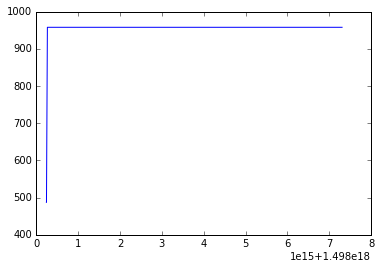

In [51]:
import pandas as pd
import numpy as np
import shlex, subprocess
import matplotlib.pyplot as plt


from netCDF4 import Dataset
ftproot = "ftp://nomads.ncdc.noaa.gov/GFS/analysis_only/"
tail = '_000.grb2'
Data_File = 'QuickData_FI.csv'
# FluxData = pd.read_csv(Data_file,delimiter = ',',header = 0)
# FluxData = FluxData.set_index(pd.DatetimeIndex(FluxData.datetime))
# FluxData['PBLH'] = -100# np.nan


Y_Lat = 69.37333333
X_Lon = -134.89000000+360

# def Extract_Data(file):
#     file = file.split('/')[-1:][0].split('.grb2')[0]+'.nc4'
#     with Dataset(file, "a") as Data:
#         print(Data.variables)
        
#         BL = Data.variables['HPBL_P0_L1_GLL0'][:]
#         TMP = Data.variables['TMP_P0_L1_GLL0'][:]
#         Lat = Data.variables['lat_0'][:]
#         Lon = Data.variables['lon_0'][:]
#     Command = "sudo rm -rf "+ file
#     args = shlex.split(Command)
#     p = subprocess.Popen(args)
#     p.wait()
#     return(BL,Lat,Lon,TMP)

# def Get_Data(file):
#     Command = """wget --user="anonymous" --password="thruhikerflash@gmail.com" """
#     Command = Command+ file
#     args = shlex.split(Command)
#     p = subprocess.Popen(args)
#     p.wait()
#     filename = file.split('/')[-1:][0]
#     Command = "ncl_convert2nc "+ filename+" -nc4c"
#     args = shlex.split(Command)
    
#     p = subprocess.Popen(args)
#     p.wait()

#     Command = "sudo rm -rf "+ filename
#     args = shlex.split(Command)
#     p = subprocess.Popen(args)
#     p.wait()
#     return(Extract_Data(file))
#     print(args)


class Get_BL:
    def __init__(self,Data_File,X_Lon,Y_Lat):
        self.XLon,self.YLat = X_Lon,Y_Lat
        FluxData = pd.read_csv(Data_file,delimiter = ',',header = 0)
        self.FluxData = FluxData.set_index(pd.DatetimeIndex(FluxData.datetime))
        self.FluxData['PBLH'] = np.nan
        self.File_List()
        for file,date in zip(self.Files[:3],self.Dates[:3]):
            print(file,date)
            self.Get_Data(file,date)
        self.FluxData['PBLH'] = self.FluxData['PBLH'].interpolate()

    def File_List(self):
        self.Files = []
        self.Dates = []
        for i in self.FluxData.index:
            ky = str(i.year)
            mo = str(i.month)
            if i.month < 10:
                mo = '0'+mo
            dy = str(i.day)
            if i.day < 10:
                dy = '0'+dy
            ky1 = ky + mo
            ky2 = ky + mo+ dy
            hr = str(i.hour)+'00'
            if i.hour < 10:
                hr = '0'+hr
            if i.hour%6 == 0:
                self.Files.append(ftproot+ky1+'/'+ky2+'/gfsanl_4_'+ky2+'_'+hr+tail)
                self.Dates.append(i)
                
    def Get_Data(self,file,date):
        Command = """wget --user="anonymous" --password="thruhikerflash@gmail.com" """
        Command = Command+ file
        args = shlex.split(Command)
        p = subprocess.Popen(args)
        p.wait()
        filename = file.split('/')[-1:][0]
        Command = "ncl_convert2nc "+ filename+" -nc4c"
        args = shlex.split(Command)

        p = subprocess.Popen(args)
        p.wait()

        Command = "sudo rm -rf "+ filename
        args = shlex.split(Command)
        p = subprocess.Popen(args)
        p.wait()
        self.Extract_Data(file,date)
            
    def Extract_Data(self,file,date):
        file = file.split('/')[-1:][0].split('.grb2')[0]+'.nc4'
        with Dataset(file, "a") as Data:
#             print(Data.variables)

            BL = Data.variables['HPBL_P0_L1_GLL0'][:]
#             TMP = Data.variables['TMP_P0_L1_GLL0'][:]
            Lat = Data.variables['lat_0'][:]
            Lon = Data.variables['lon_0'][:]
        Command = "sudo rm -rf "+ file
        args = shlex.split(Command)
        p = subprocess.Popen(args)
        p.wait()
        XL = np.where(Lon == Lon[Lon>self.XLon].min())[0][0]
        YL = np.where(Lat == Lat[Lat>self.YLat].min())[0][0]
        print(BL[YL:YL+2,XL:XL+2].mean())
        self.FluxData.loc[self.FluxData.index == date,'PBLH'] = BL[YL:YL+2,XL:XL+2].mean()
        print(self.FluxData.loc[self.FluxData.index == date,'PBLH'])
        
            
BL = Get_BL(Data_File,X_Lon,Y_Lat)
plt.figure()
plt.plot(BL.FluxData['PBLH'])
#     else:
#         print(i)
# for Date in Dates:
#     FluxData.loc[FluxData.index == Date,'PBLH']=100
# plt.figure()
# plt.plot(FluxData['PBLH'])
# # plt.xlim(0,100)
# print(FluxData['PBLH'])
# plt.show()
# BL_Time=[]
# for f in Files[:5]:
#     BL,Lat,Lon,TMP = Get_Data(Files[-1])
#     xarr = Lon-X_Lon
#     yarr = Lat-Y_Lat

#     XL = np.where(Lon == Lon[Lon>X_Lon].min())[0][0]
#     YL = np.where(Lat == Lat[Lat>Y_Lat].min())[0][0]
#     BL_Time.append(BL[YL:YL+2,XL:XL+2].mean())
# plt.figure()
# plt.plot(np.asanyarray(BL_Time))
#     print(temp)

In [50]:
print(BL.FluxData.loc[BL.FluxData['PBLH']==BL.FluxData['PBLH'].max()])
print(BL.FluxData['PBLH'])
# X1 = (np.round(np.max(xarr[xarr < 0])+X_Lon,2))
# Y1 = (np.round(np.max(yarr[yarr < 0])+Y_Lat,2))
# X2 = (np.round(np.min(xarr[xarr > 0])+X_Lon,2))
# Y2 = (np.round(np.min(yarr[yarr > 0])+Y_Lat,2))


Empty DataFrame
Columns: [datetime, datetime.1, DOY, daytime, file_records, used_records, Tau, qc_Tau, H, qc_H, LE, qc_LE, co2_flux, qc_co2_flux, h2o_flux, qc_h2o_flux, ch4_flux, qc_ch4_flux, H_strg, LE_strg, co2_strg, h2o_strg, ch4_strg, co2_v-adv, h2o_v-adv, ch4_v-adv, co2_molar_density, co2_mole_fraction, co2_mixing_ratio, co2_time_lag, co2_def_timelag, h2o_molar_density, h2o_mole_fraction, h2o_mixing_ratio, h2o_time_lag, h2o_def_timelag, ch4_molar_density, ch4_mole_fraction, ch4_mixing_ratio, ch4_time_lag, ch4_def_timelag, sonic_temperature, air_temperature, air_pressure, air_density, air_heat_capacity, air_molar_volume, ET, water_vapor_density, e, es, specific_humidity, RH, VPD, Tdew, u_unrot, v_unrot, w_unrot, u_rot, v_rot, w_rot, wind_speed, max_wind_speed, wind_dir, yaw, pitch, roll, u*, TKE, L, (z-d)/L, bowen_ratio, T*, model, x_peak, x_offset, x_10%, x_30%, x_50%, x_70%, x_90%, un_Tau, Tau_scf, un_H, H_scf, un_LE, LE_scf, un_co2_flux, co2_scf, un_h2o_flux, h2o_scf, un_ch4_flu

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)

X,Y = np.meshgrid(x,y)
Z = X



f, (ax, ax2) = plt.subplots(1,2)
cmap = plt.get_cmap('RdYlBu')

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
xl = ax.get_xlim()
yl = ax.get_ylim()
XL = np.where(((x>xl[0]))&(x<xl[1]))
YL = np.where(((y>yl[0])&(y<yl[1])))
Zrange = Z.reshape(100,-1)[XL,YL]
Vmin,Vmax = Zrange.min(),Zrange.max()
v = np.linspace(Vmin,Vmax,15, endpoint=True)
cax = ax.contourf(X,Y,Z,256,cmap=cmap, vmin = Vmin, vmax=Vmax)
cbar = fig.colorbar(cax, cmap=cmap,ax=ax,ticks=v)
cbar.set_clim(v[0],v[1])

cax2 = ax2.contourf(X,Y,Z,256,cmap=cmap, vmin = np.min(Z), vmax=np.max(Z))
cbar2 = fig.colorbar(cax2, cmap=cmap,ax=ax2)

plt.show()

# Possibly some useful stuff here

In [ ]:
"""
plot H's and L's on a sea-level pressure map
(uses scipy.ndimage.filters and netcdf4-python)
"""
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.basemap import Basemap, addcyclic
from scipy.ndimage.filters import minimum_filter, maximum_filter
from netCDF4 import Dataset

def extrema(mat,mode='wrap',window=10):
    """find the indices of local extrema (min and max)
    in the input array."""
    mn = minimum_filter(mat, size=window, mode=mode)
    mx = maximum_filter(mat, size=window, mode=mode)
    # (mat == mx) true if pixel is equal to the local max
    # (mat == mn) true if pixel is equal to the local in
    # Return the indices of the maxima, minima
    return np.nonzero(mat == mn), np.nonzero(mat == mx)

# plot 00 UTC today.
date = datetime.now().strftime('%Y%m%d')+'00'
print(date)
date = '2017110900'

# open OpenDAP dataset.
temp = "http://nomads.ncep.noaa.gov:9090/dods/gfs/gfs/%s/gfs_%sz_anl" %\
       (date[0:8],date[8:10])
print(temp)
# "https://nomads.ncdc.noaa.gov/data/gfsanl/200403/20040310/

data=Dataset("https://nomads.ncdc.noaa.gov/data/gfsanl/200404/20040402/gfsanl_3_20040402_0000_000.grb")#"http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfs20171111/gfs_0p25_00z_anl")
    #"http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20171109/gfs_0p50_00z")#%\
#         (date[0:8],date[8:10]))



# read lats,lons.
lats = data.variables['lat'][:]
lons1 = data.variables['lon'][:]
print(data.variables)
nlats = len(lats)
nlons = len(lons1)
# read prmsl, convert to hPa (mb).
prmsl = 0.01*data.variables['prmslmsl'][0]
# the window parameter controls the number of highs and lows detected.
# (higher value, fewer highs and lows)
local_min, local_max = extrema(prmsl, mode='wrap', window=50)
# create Basemap instance.
m = Basemap(llcrnrlon=0,llcrnrlat=-80,urcrnrlon=360,urcrnrlat=80,projection='mill')
# add wrap-around point in longitude.
prmsl, lons = addcyclic(prmsl, lons1)
# contour levels
clevs = np.arange(900,1100.,5.)
# find x,y of map projection grid.
lons, lats = np.meshgrid(lons, lats)
x, y = m(lons, lats)
x = x.astype(int)
y = y.astype(int)
print(type(x),y)
# create figure.
fig=plt.figure(figsize=(8,4.5))
ax = fig.add_axes([0.05,0.05,0.9,0.85])
print(m)
cs = m.contour(x,y,prmsl,clevs,colors='k',linewidths=1.)
m.drawcoastlines(linewidth=1.25)
m.fillcontinents(color='0.8')
m.drawparallels(np.arange(-80,81,20),labels=[1,1,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
xlows = x[local_min]; xhighs = x[local_max]
ylows = y[local_min]; yhighs = y[local_max]
lowvals = prmsl[local_min]; highvals = prmsl[local_max]
# plot lows as blue L's, with min pressure value underneath.
xyplotted = []
# don't plot if there is already a L or H within dmin meters.
yoffset = 0.022*(m.ymax-m.ymin)
dmin = yoffset
for x,y,p in zip(xlows, ylows, lowvals):
    if x < m.xmax and x > m.xmin and y < m.ymax and y > m.ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'L',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='b')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='b',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))
# plot highs as red H's, with max pressure value underneath.
xyplotted = []
for x,y,p in zip(xhighs, yhighs, highvals):
    if x < m.xmax and x > m.xmin and y < m.ymax and y > m.ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'H',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='r')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='r',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))
plt.title('Mean Sea-Level Pressure (with Highs and Lows) %s' % date)
plt.show()

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='l')
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))
# make up some data on a regular lat/lon grid.
nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
x, y = map(lons*180./np.pi, lats*180./np.pi)
# contour data over the map.
cs = map.contour(x,y,wave+mean,15,linewidths=1.5)
plt.title('contour lines over filled continent background')
plt.show()